# Mel Schwan, Stuart Miller, Justin Howard, Paul Adams
# Lab Two: Classification

## MiniLab2 Project Requirments -
1. [Data Preparation](#DataPreparation)
    1. [Define and prepare your class variables](#Define)
    2. [Describe the final dataset that is used for classification/regression (include a
description of any newly formed variables you created](#FinalDataset)


2. [Modeling and Evaluation](#DataUnderstanding)
    1. [Choose and explain your evaluation metrics that you will use](#Evaluaation)
    2. [Choose the method you will use for dividing your data into training and
testing splits](#DivideData)
    3. [Create three different classification/regression models](#Models)
    4. [Analyze the results using your chosen method of evaluation](#Analyze)
    5. [Discuss the advantages of each model for each classification task](#Advantages)
    6. [Which attributes from your analysis are most important](#Attributes)
    
    
3. [Deployment](#Deployment)
    1. [How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? ](#Attributes)
    2. [How would you measure the model's value if it was used by these parties?](#Attributes)
    3. [How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?](#Value)

A1. [Disclaimer](#Disclaimer)

<img src="./crisps-dm2.png" style="width:550px;height:450px"/>


# Dataset Selection

# 1. Stage Three - Data Preperation (Q1)   <a class="anchor" id="DataPreparation"></a>

## 1.1 Define and prepare your class variables (Q1A)<a class="anchor" id="Define"></a>

In [324]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#plotting library
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# others
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import IFrame
from math import log
from pandas_profiling import ProfileReport

# custom functions
from cleaning import (read_clean_data, impute_data, merge_bureau, merge_previous_application,
merge_POS_CASH, merge_credit_card_balance, merge_installments, downsampling_strategy, reduce_mem_usage)
from tables import classification_report

# set random seed
random_state= 1
np.random.seed(random_state)

## 1.0 Loading and Merging the Dataset

```python

# loading data that was preprocessed using the custom read_clean_data() function, 
# merged with the previously engineered newFeatures from Lab 1 
data = read_clean_data()
```

```python
data_bureau = merge_bureau(data)
data_prev = merge_previous_application(data_bureau)
data_POS_CASH = merge_POS_CASH(data_prev)
data_installments = merge_installments(data_POS_CASH)
data_full = merge_credit_card_balance(data_installments)
```

In [ ]:
```
The shape application and bureau data combined: (307511, 115)
Dimensions after adding new features:  (307511, 119)
Dimensions after adding previous_application:  (307511, 282)
Dimensions after adding POS_CASH_balance:  (307511, 296)
Dimensions after adding installments:  (307511, 302)
Dimensions after adding credit_card_balance:  (307511, 329)
```

In [319]:
#For ease of use, data was saved to CSV files and reloaded
X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train.txt', header = None).values.flatten()
y_test = pd.read_csv('y_test.txt', header = None).values.flatten()

### 1.1 Data Preparation Explanation

The data from seven different tables was merged into one dataset for use in the analysis. The following list is a general set of procedures that were followed to complete the merge. The explicit code used to merge the datasets can be located in the reference file [cleaning.py](/cleaning.py).

Multiple records exist with several rows for each unique record in the current application dataset, all categorical variables were one-hot encoded, then grouped by the unique identifier in the application dataset. After that, the mean of each grouping was taken to condense the features to a single float value. This method was applied to the following list of tables:
- bureau.csv
- previous_application.csv
- POS_CASH_BALANCE.csv
- installments.csv
- credit_card_balance.csv

In [5]:
```python
data_lite = reduce_mem_usage(data_full)
```

Memory usage of dataframe is 735.51 MB
Memory usage after optimization is: 202.06 MB
Decreased by 72.5%


In [ ]:
```
Memory usage of dataframe is 735.51 MB
Memory usage after optimization is: 202.06 MB
Decreased by 72.5%
```

In [4]:
```python
data.CNT_FAM_MEMBERS.unique()
```

array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])

In [ ]:
```
array([ 1.,  2.,  3.,  4.,  5.,  6.,  9.,  7.,  8., 10., 13., 14., 12.,
       20., 15., 16., 11.])
```

The dataset contains features, such as the number of children an applicant has, where the number of unique values are relatively high, but the percentage of the total makeup is almost imperceptable. The distributions of these high cardinality variables are heavily skewed. To address this issue, the number of numeric categories was reduced to get a more accurate interpretation of their impact on the target variable.

In [5]:
```python
#recoding least valuable cateogries into meaningful bins

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'
```

## 1.2 Sampling strategies

**Resampling the Training Data**

Initially, the models were trained against training data that contained mostly non-defaulting instances. However, the model's performance on this initial training data was inferior, generally failing to classify any defaulting instances. The remedy to this issue was to resample the training data to balance the number of non-defaulting and defaulting instances. All the defaulting instances were retained, but the non-defaulting instances were randomly downsampled to match the number of non-defaulting instances. Resampled training data improved the performance of the models substantially when validated on the test data. 

The test data was **not** resampled.

Additionally, the categroical variables were label encoded, rather than one-hot encoded.

### 1.2.2 Downsampling to achieve balance

Our metric of choice is recall, which can be improved most effectively by balancing the training set. We have used two strategies that selectively under-sample the data, but an imbalance between the number of defaulted loans and non-defaulted loans still persists. We will create a final training set that has defaults and non-defaulted loans represented equally.

In [36]:
```python
def downsampling_strategy(X, y):
    y.columns = ['TARGET']
    X = X.copy(deep=True)
    y = y.copy(deep=True)
    y = y.to_frame(name = 'TARGET')
    random_state = 1
    # balancing the training set
    df = pd.concat([X, y], axis =1)
    defaults = df[df['TARGET'] == 1]
    nominal = df[df['TARGET'] == 0].sample(
        n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int), random_state = random_state)
    # join dataframes and shuffle
    df = pd.concat([defaults, nominal]).sample(frac = 1, random_state = random_state)
    return df
data_final = downsampling_strategy(X_tl, y_tl)
print('Final Data shape: ', data_final.shape,
     'Percent defaults: ', data_final[data_final['TARGET'] == 1].shape[0] / data_final.shape[0])
```

Final Data shape:  (33778, 327) Percent defaults:  0.5


### 1.1.1 Principal Component Analysis

Our feature selection decisions prompted a review of the Principal Components to see if a more significant separation between the classes is evident. We dropped variables that seemed the least useful for this type of analysis. Next, we on-hot encoded to eliminate the duplication of categorical features that were already binary indicators.

In [38]:
# dropping variables that were deemed the least useful for analysis
y_train = data_final.TARGET.copy()
new_df = data_final.copy().drop(['TARGET'], axis = 1)
new_df = new_df.fillna(0)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33778 entries, 166872 to 134341
Columns: 326 entries, NAME_CONTRACT_TYPE to CREDIT_NAME_CONTRACT_STATUS_Signed
dtypes: float32(276), int8(50)
memory usage: 37.4 MB


In [39]:
sc = StandardScaler()
sc.fit(new_df)
X_std = sc.transform(new_df) 
X_std.shape

(33778, 326)

In [40]:
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nTop Ten Eigenvalues \n%s' % eigen_vals[0:9])


Top Ten Eigenvalues 
[18.43774279 10.16494678  9.12500087  6.66609231  5.71167223  5.12202143
  4.80021381  4.17555201  3.84662142]


In [41]:
# calculating the total var explained and cumulative variance
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse =True)]
cum_var_exp = np.cumsum(var_exp)
len(var_exp)
len(cum_var_exp)
print("Variance Explained length: " + str(len(var_exp)), "\nCumulative Variance Explained length : " + str(len(cum_var_exp)))

Variance Explained length: 326 
Cumulative Variance Explained length : 326


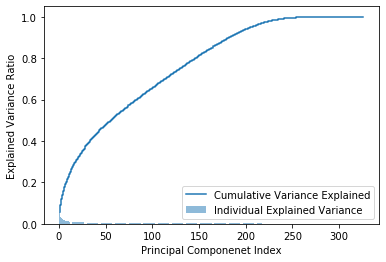

In [42]:
plt.bar(range(1,327), var_exp, alpha = .5, align = 'center', label = 'Individual Explained Variance')

plt.step(range(1,327), cum_var_exp, where = 'mid', label = 'Cumulative Variance Explained')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Componenet Index')
plt.legend(loc='best')
plt.show()

**Significant Findings**

To capture at least 80% of the variability in the dataset, we must include around 150 principal components. While this is a large number of features, our previous dataset contained 302 features. Our efforts to reduce the cardinality of several features were effective. 

We will pair the eigenvectors with their corresponding eigenvalues and project them onto a 2-dimensional subspace and observe the results.

In [43]:
# making a listof (eigenvalues, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

#sort the (eigenvalue, eigenvector) tuples from high to low
"""eigen_pairs[0] is equivalent to the single eigenvalue for PC1 and the eigenvector that represents the 190 features of the data"""
eigen_pairs.sort(key=lambda k: k[0], reverse = True)

#collecting the two eigenvectors that correspond to the two largest eigenvalues

W = np.hstack((eigen_pairs[0][1][:,np.newaxis],
               eigen_pairs[1][1][:,np.newaxis]))

# printing the first 5 pairs
print('Matrix W: \n', W[:5])

Matrix W: 
 [[-0.03112655 -0.00332737]
 [ 0.01428164  0.02652703]
 [-0.00576126  0.00453904]
 [ 0.0153833   0.02209266]
 [ 0.00340376  0.00048951]]


We can use this matrix to transform the training set into new features and plot them. First, we will observe the first 2 Principal Components with a logistic regression-based decision boundary to view the discriminatory ability of a logistic model using the Principal Components.

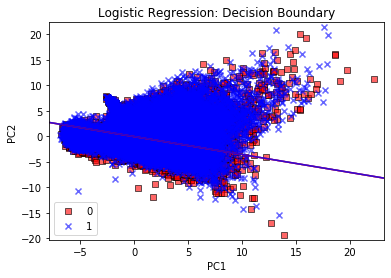

In [45]:
#transforming data
X_pca = X_std.dot(W)

# identifying labels
y_pca = data_final.TARGET.copy()

#initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components =2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')
# dimensionality reduction:
X_pca = pca.fit_transform(X_std)
#fitting the logitistic regression model on the reduced dataset:
lr.fit(X_pca, y_pca)
plot_decision_regions(X_pca, y_pca, classifier = lr)
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'lower left')
plt.show()

**Significant Findings**

From this plot, we can see that class separation is very poor and non-linear. We have two centroids where each has only a slight concentric-ellipse type of separation between the two classes. The decision boundary drawn by a logistic model is clearly unable to use the first two principal components to discriminate between defaults and non-defaulted loans.


We can also attempt to view the value of the third principal component to see if there is good separation when we add a third dimension.

In [46]:
# getting three principal components
W3 = np.hstack((W,eigen_pairs[2][1][:,np.newaxis]))
W3.shape

(326, 3)

In [47]:
#transforming training data
X_pca3 = X_std.dot(W3)
X_pca3.shape

(33778, 3)

In [48]:
X_pca3[:10,:]

array([[-5.02937674, -0.98626814, -1.30637781],
       [-2.01549137, -6.42485912, 10.76923357],
       [ 2.28124558, -3.86540618, -1.64788073],
       [ 0.73152602,  0.1714851 ,  1.98469044],
       [-0.96959981,  1.64431276,  0.31434482],
       [-6.39735164, -0.50218682, -2.14297191],
       [ 6.84454901,  3.46870767,  4.46499208],
       [-2.17301617,  0.66477394,  0.55293713],
       [-5.07053559, -0.2440994 , -1.20476297],
       [-5.10194594, -1.73257925, -0.3966984 ]])

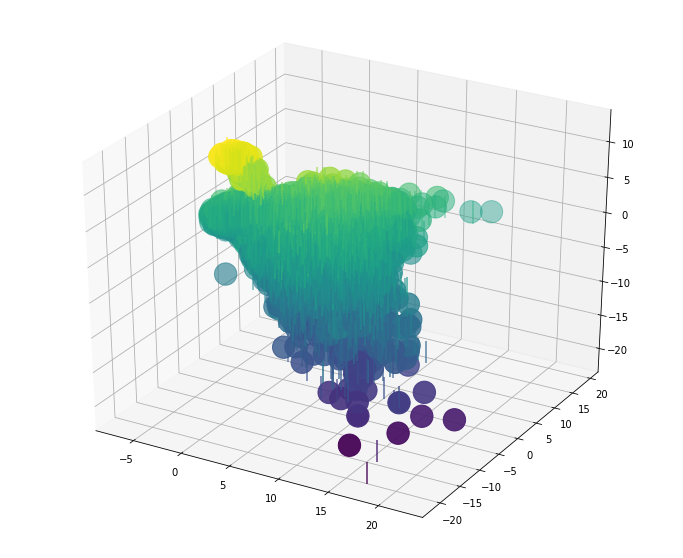

In [52]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection = '3d')


colors = ['r','g']
markers = ['o', '|']

# for each index and class in:
for idx, cl in enumerate(np.unique(y_pca)):
    ax.scatter3D(X_pca3[y_pca == cl, 0],
                X_pca3[y_pca == cl, 1],
                X_pca3[y_pca == cl, 2],
                label = cl,
                s=500,
                c = X_pca3[y_pca == cl, 2],
                cmap = 'viridis',
                marker = markers[idx])

**Significant Findings**

A three dimensional plot of the data does provide some insights. Defaults can be separated along the third dimension, as indicated by the defaults being clustered in the blue region and the non-defaults being clustered in the green/yellow regions of the third Principal Component.

1. The overlap between the classes is so signficant even in the third dimension, that the boundary line is not clear.

### 1.1.2 Feature Importance Assessment

An analysis of feature importance was performed by removing features with high variance inflation factor (VIF) and ranking features by absolute mean feature importance from an ensemble of models (regularized logistic regression).

#### 1.1.2.1 Feature Removal By VIF

High VIF is an [indication of multicollinearity](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).
Typically, limiting VIF of individual features to 5 is considered reasonable.
For removal by VIF, features with high VIF were removed iteratively until the VIF for all remain features was less than 5.
The VIF reduction method removed 75 features, leaving 251 features.
The full list of dropped features is shown below.

```python
transformer = ReduceVIF()
X = transformer.fit_transform(X_train)
```

In [23]:
IFrame("./vif_features.html", width=700, height=400)

#### 1.1.2.2 Feature Importance From Ensemble

The training data was split into training and validation sets (80/20) split - 
the validation split is used in the performance estimation.
Feature Importance was estimated by training a logstic model with L2 regularization and a logistic model with L1 regularization on the training set with the reduced number of features.
Once the models were fit, the model weights were extracted and combined for each feature.
The features were ranked by the average of the absolute value of the model weights.
The table is shown below

**Column Meanings**

* `Mean_Abs_Weight`: The mean of the absolute values of the weights assigned to features by the logistic models.
* `Feature`: The feature name.
* `l1_Weight`: The parameter weight assigned my the logistic model with L1 regularization.
* `l2_Weight`: The parameter weight assigned my the logistic model with L2 regularization.
* `Importance_Difference`: The difference btween the weight assigned by the LASSO logistic model and the weight assigned by the ridge logistic regression model.
* `Importance_Difference_%`: The percent difference between the weight assigned by the LASSO logistic model and the weight assigned by the ridge logistic regression model.

In [25]:
IFrame("./feature_importance.html", width=1200, height=400)

In [254]:
X = X_train
X_val = X_test
y = y_train
y_val = y_test

# train logistic models
logistic_l1 = LogisticRegression(C = 0.01,
                                 penalty = 'l1', 
                                 solver = 'saga', 
                                 random_state = random_state)
logistic_l1.fit(X, y)

logistic_l2 = LogisticRegression(C = 0.01, 
                                 penalty = 'l2',
                                 solver = 'lbfgs', 
                                 random_state = random_state)
logistic_l2.fit(X, y)

# extract the l1 coefficients
coefs = logistic_l1.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l1 = df_new_coeffs.sort_values('Logistic Weight')
final_df_logistic_l1['Abs Weight'] = np.abs(final_df_logistic_l1['Logistic Weight'])
final_df_logistic_l1.sort_values('Abs Weight', ascending=False, inplace = True)

# extract the l2 coefficients
coefs = logistic_l2.coef_
pd.set_option('display.max_rows', 500)
coefs_df = pd.DataFrame(data=coefs.flatten())
feats_df = X.columns
feats_df = feats_df.tolist()
feats_df = pd.DataFrame(feats_df)
df_new_coeffs = pd.concat([feats_df, coefs_df], axis=1).dropna()
df_new_coeffs.columns = ['Feature', 'Logistic Weight']
final_df_logistic_l2 = df_new_coeffs.sort_values('Logistic Weight')
final_df_logistic_l2['Abs Weight'] = np.abs(final_df_logistic_l2['Logistic Weight'])
final_df_logistic_l2.sort_values('Abs Weight', ascending=False, inplace = True)

# prevent risk of object corruption
l2 = final_df_logistic_l2.sort_values('Feature').copy().add_suffix('_l2')
l1 = final_df_logistic_l1.sort_values('Feature').copy().add_suffix('_l1')

# combine the feature weights, calculate mean abs, and sort
# just print the head
combined = pd.concat([l1, l2], keys=['Feature_l1', 'Feature_l2'], axis = 1)
combined['Average Weight'] = (combined['Feature_l1']['Abs Weight_l1'] 
                              + combined['Feature_l2']['Abs Weight_l2']) / 2
average_weights = pd.DataFrame()
average_weights['Mean_Abs_Weight'] = combined['Average Weight']
average_weights['Feature'] = combined['Feature_l1']['Feature_l1']
average_weights['l1_Weight'] = combined['Feature_l1']['Logistic Weight_l1']
average_weights['l2_Weight'] = combined['Feature_l2']['Logistic Weight_l2']
average_weights['Importance_Difference'] = average_weights['l1_Weight'] - average_weights['l2_Weight']
average_weights['Importance_Difference_%'] = (average_weights['Importance_Difference'] 
                                              / average_weights['Mean_Abs_Weight'] 
                                              * 100)
average_weights = average_weights.sort_values('Mean_Abs_Weight', ascending = False).reset_index(drop = True)
average_weights.head(10)

,Mean_Abs_Weight,Feature,l1_Weight,l2_Weight,Importance_Difference,Importance_Difference_%
0,0.399264,EXT_SOURCE_2,-0.402829,-0.395699,-0.007130,-1.785808
1,0.381053,EXT_SOURCE_3,-0.377268,-0.384837,0.007569,1.986399
2,0.257468,NAME_EDUCATION_TYPE,-0.060687,-0.454249,0.393562,152.858748
3,0.250792,POS_CNT_INSTALMENT_FUTURE,0.140188,0.361395,-0.221208,-88.203829
4,0.168159,INSTA_AMT_PAYMENT,-0.037588,-0.298730,0.261142,155.294656
5,0.161911,CODE_GENDER,-0.155459,-0.168363,0.012904,7.970049
6,0.158340,PREV_CNT_PAYMENT,0.150242,0.166439,-0.016197,-10.229270
7,0.147774,EXT_SOURCE_1,-0.149103,-0.146446,-0.002657,-1.798160
8,0.134381,FLAG_DOCUMENT_3,0.103911,0.164852,-0.060941,-45.349103
9,0.124358,FLAG_OWN_CAR,0.000000,-0.248717,0.248717,200.000000


#### 1.1.2.3 Estimation of Performance Over Feature Space

Once the features were ranked, the number of features needed for classification was estimated by iterative training and testing a logistic model and a hist gradient boosting model on the ranked feature set.
On each iteration, 5 features were added to the feature space used by the model for training and testing until the maximum feature space was reached.
The following plots show the model performance over the feature space.
The logistic model appears to stabilize once the top 50 features were added to the model, while the HGBM appears to stablity once the top 75 features were added to the model.
The models were tested on the 20% validation split from the training data.

In [61]:
# hold feature performance
log_acc = list()
log_recall = list()
log_pre = list()
feat_count = list()
hgbm_acc = list()
hgbm_recall = list()
hgbm_pre = list()
feat_count = list()

# init models
# models use baseline regularization
l = LogisticRegression(C = 0.01, 
                       penalty = 'l2',
                       solver = 'lbfgs', 
                       random_state = random_state)

clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)

# calculate performance over by iterative adding features
# with a step size of 5
for f_count in range(10, 260, 5):
    feat_count.append(f_count)
    
    l.fit(X[average_weights.iloc[0:f_count].Feature], y)

    # using it on test set
    y_pred = l.predict(X_val[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    log_acc.append(accuracy_score(y_val, y_pred))
    log_pre.append(precision_score(y_val, y_pred))
    log_recall.append(recall_score(y_val, y_pred))

feat_count = list()
for f_count in range(10,260,5):
    feat_count.append(f_count)
    
    clf.fit(X[average_weights.iloc[0:f_count].Feature], y)

    # using it on test set
    y_pred = clf.predict(X_val[average_weights.iloc[0:f_count].Feature])
    #results = confusion_matrix(y_test, y_pred)

    hgbm_acc.append(accuracy_score(y_val, y_pred))
    hgbm_pre.append(precision_score(y_val, y_pred))
    hgbm_recall.append(recall_score(y_val, y_pred))

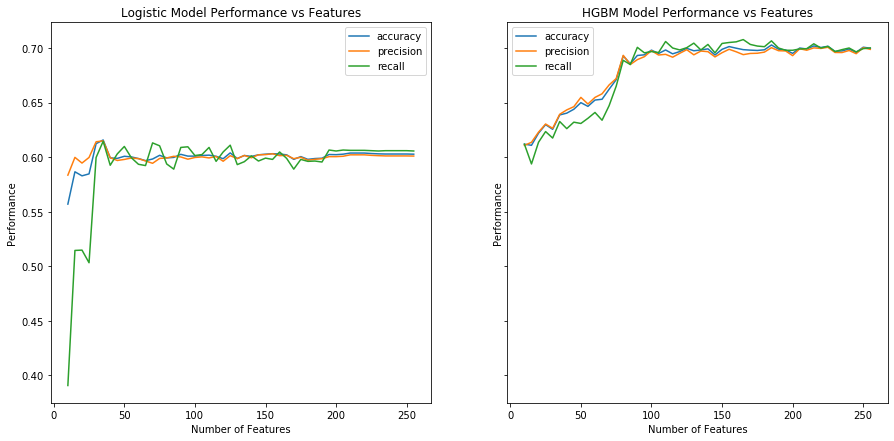

In [62]:
# plot the performance of both models
fig, ax = plt.subplots(ncols=2, sharey = True, figsize=(15,7))

ax[0].plot(feat_count, log_acc, label = 'accuracy')
ax[0].plot(feat_count, log_pre, label = 'precision')
ax[0].plot(feat_count, log_recall, label = 'recall')
ax[0].legend()
ax[0].set_title('Logistic Model Performance vs Features')
ax[0].set_xlabel('Number of Features')
ax[0].set_ylabel('Performance')
#plt.ylim((0.68, 0.74))

ax[1].plot(feat_count, hgbm_acc, label = 'accuracy')
ax[1].plot(feat_count, hgbm_pre, label = 'precision')
ax[1].plot(feat_count, hgbm_recall, label = 'recall')
ax[1].legend()
ax[1].set_title('HGBM Model Performance vs Features')
ax[1].set_xlabel('Number of Features')
ax[1].set_ylabel('Performance')
#plt.ylim((0.68, 0.78))
plt.show();

In [320]:
keepers = average_weights.Feature[:100].values
# using the previously scaled dataset and removing less important features
X_train = X_train[keepers]
X_test = X_test[keepers]

In [321]:
X_train.shape

(39720, 100)

In [325]:
profile = ProfileReport(X_train, minimal=True)
profile.to_file(output_file = 'Lab_2_data.html')

## 1.2 Describe the final dataset that is used for classification/regression (Q1B)<a class="anchor" id="FinalDataset"></a>


The final training set contains 39,720 records and the 100 most important attributes to predictor the value of `TARGET`. The features are a combination of continuous variables, binary indicators, and label encoded ordinal features. A full report of the distributions of the selected features is available in the following HTML rendered report:

In [ ]:
IFrame("./Lab_2_data.html", width=1200, height=400)

## 2.  Stage Four - Modeling and Evaluation (Q2) <a class="DataUnderstanding" id="EDA"></a>

## 2.1 Choose and explain your evaluation metrics (Q2A) <a class="anchor" id="Evaluaation"></a>


Due to the significant overlap between the classes in our dataset, we have elected to evaluate our models using the recall metric. Recall is the ratio of accurately predicted defaults to total defaults, which allows us to extract value from the model. 

## 2.2 Choose the method you will use for dividing your data (Q2B) <a class="anchor" id="Describedata"></a>

We are using an 80/20 training : test set split.

As previously mentioned in section 1.2 (Data Description) we concluded that it was necessary to implement a sampling strategy on the training set in order to make a useful model for predicting loan defaults. 

As a justification of the use of a generic sampling strategy with this dataset, we will provide an example of the effectiveness of simple Randum Under Sampling.

## 2.3.1 Three Classification Models (Q2C) <a class="anchor" id="Models"></a>

### 2.3.1.1 Histogram Based Gradient Boosted Decision Tree

#### Applying a Grid Search

In [289]:

g_clf = HistGradientBoostingClassifier(random_state = random_state)

grid_values = {
    'loss': ['binary_crossentropy', 'categorical_crossentropy'],
    'learning_rate': [.05, .1],
    'max_iter': [100, 125],
    'max_leaf_nodes': [41, 51],
    'min_samples_leaf': [10, 20],
    'l2_regularization':[0,.01],
    'random_state': [random_state]
}

grid_clf = GridSearchCV(g_clf, param_grid = grid_values)

grid_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                      learning_rate=0.1,
                                                      loss='auto', max_bins=255,
                                                      max_depth=None,
                                                      max_iter=100,
                                                      max_leaf_nodes=31,
                                                      min_samples_leaf=20,
                                                      n_iter_no_change=None,
                                                      random_state=1,
                                                      scoring=None, tol=1e-07,
                                                      validation_fraction=0.1,
                                                      verbose=0,
                                                      warm_start=False),
 

In [290]:
print(grid_clf.best_params_)

{'l2_regularization': 0.01, 'learning_rate': 0.1, 'loss': 'binary_crossentropy', 'max_iter': 100, 'max_leaf_nodes': 51, 'min_samples_leaf': 10, 'random_state': 1}


In [255]:
clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = random_state)
clf.fit(X,y)
print('5-fold cross validation results: ',cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'recall'))

5-fold cross validation results:  [0.71299094 0.70417925 0.68907351 0.69964753 0.69209466]


In [256]:
hgbm_preds = grid_clf.predict(X_test)
results = confusion_matrix(y_test, hgbm_preds)

accuracy = (results[0][0] + results[1][1])/(len(hgbm_preds))
precision = results[1][1]/(results[0][1] + results[1][1])
recall = results[1][1]/ (results[1][0] + results[1][1])

print(results,
      '\nAccuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

[[3392 1573]
 [1284 3681]] 
Accuracy: 0.7122860020140986 
Precision: 0.7006090597639894 
Recall: 0.7413897280966767


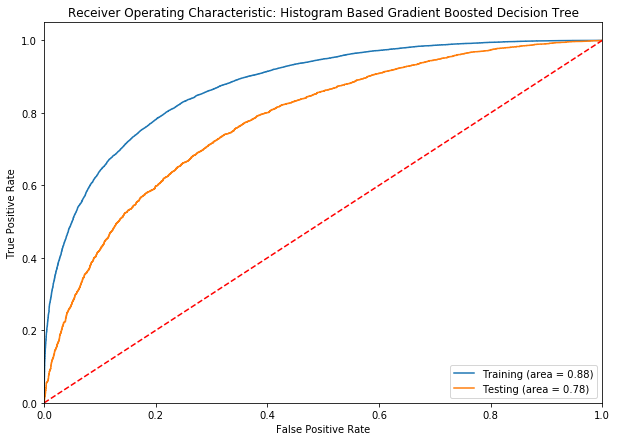

In [292]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve



fpr, tpr, thresholds = roc_curve(y_train, grid_clf.predict_proba(X_train)[:,1])
roc_auc = auc(fpr,tpr)

fpr_t, tpr_t, thresholds_t = roc_curve(y_test, grid_clf.predict_proba(X_test)[:,1])
roc_auc2 = auc(fpr_t,tpr_t)

#plotting
plt.figure(figsize = (10, 7))
plt.plot(fpr, tpr, label= 'Training (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, label= 'Testing (area = %0.2f)' % roc_auc2)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic: Histogram Based Gradient Boosted Decision Tree')
plt.legend(loc = 'lower right')
plt.show()

### 2.3.1.2 Random Forest

This model provided a precision of XX% and a recall of XX% (AUC of 0.75) when trained with the best model parameters and validated on the test data.

In [284]:
model = RandomForestClassifier(random_state = random_state)
model.fit(X_train, y_train)
y_pred_svm = model.predict(X_test)
classification_report(y_test, y_pred_svm)

Classification Report

Confusion Matrix
Predicted   0.0   1.0   All
True                       
0.0        3375  1590  4965
1.0        1422  3543  4965
All        4797  5133  9930

Accuracy: 69.67% 
Precision: 69.02% 
Recall: 71.36%


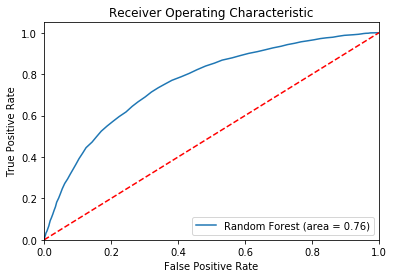

In [285]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test,
                                 model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

## 2.3.2 Three Regression Models (Q2C) <a class="anchor" id="Models"></a>

To perform a regression on a continuous variable, we picked a variable with the highest importance to the initial application, EXT_SOURCE_2. Since our predictor and our modeling strategy has changed, we must re-evaluate our assumptions to match those of linear regression. We are aware of several highly skewed features, such as `AMT_INCOME_TOTAL` and `AMT_ANNUITY` and must apply a log transformation to meet the normality and equal variance assumptions of Linear Regression.

In [261]:
data_reg = read_clean_data(preimpute = False)

In [262]:
data_reg = data_reg.dropna(axis=1)
data_reg.shape

(307511, 70)

We also viewed the variables for evidence of multicollinearity and found that all `EXT_SOURCE` variables were not at all collinear. Although the `EXT_SOURCE` variables are highly skewed, the documentation states that they are already standardized, making further transformations of these variables problematic. We have decided not to transform these variables. Our dataset also contains a large number of binary indicator variables, so these features will not be transformed. 

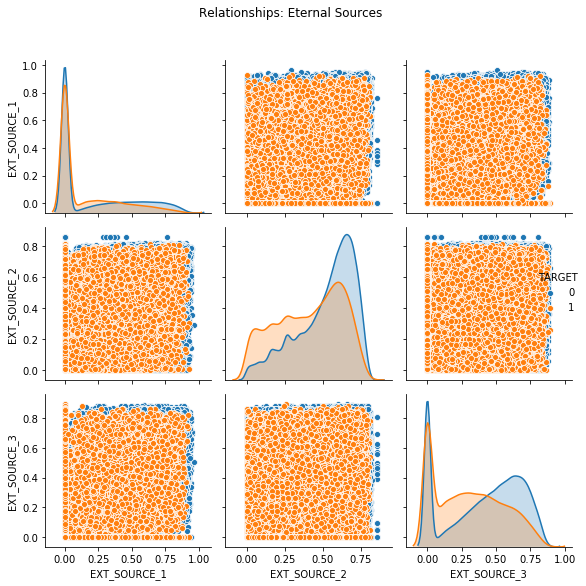

In [299]:
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
g = sns.pairplot(data_reg[cols], hue = 'TARGET')
g.fig.suptitle('Relationships: Eternal Sources', y= 1.08)
plt.tight_layout()
plt.show()

In [310]:
# applying log transformations to non-binary values
log_data = data_reg.copy()
for col in log_data.columns.values:
    if log_data[col].min() != 0 and log_data[col].max() != 1:
        log_data[col] = log_data[col].apply(np.log)
        

In [311]:
log_data.describe()

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EMPLOYED,cnt_child,cnt_family,CREDIT_INCOME_RATIO,PERCENT_EMPLOYED_TO_AGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.080729,0.095213,0.340108,0.693673,11.909238,13.070105,5.227192,4.670288,3.188273,1.472312,...,0.006055,0.029723,0.231293,0.229631,1.643447,0.819928,1.401147,1.137120,1.160868,0.128615
std,0.272419,0.293509,0.473746,0.460968,0.488910,0.715196,1.775645,2.544525,1.298753,1.168884,...,0.103037,0.190728,0.856810,0.744059,1.855821,0.384248,0.915792,0.863878,0.675518,0.135117
min,0.000000,0.000000,0.000000,0.000000,10.152299,10.714418,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.337554,0.000000
25%,0.000000,0.000000,0.000000,0.000000,11.630709,12.506177,6.000000,3.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.702437,0.021559
50%,0.000000,0.000000,0.000000,1.000000,11.899208,13.149066,6.000000,7.000000,4.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.183280,0.088645
75%,0.000000,0.000000,1.000000,1.000000,12.218495,13.603121,6.000000,7.000000,4.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,2.000000,1.640913,0.191000
max,1.000000,1.000000,1.000000,1.000000,18.577684,15.214227,7.000000,7.000000,4.000000,5.000000,...,9.000000,8.000000,27.000000,261.000000,25.000000,1.000000,2.000000,3.000000,4.439550,0.728811


In [312]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(log_data.drop(labels = ['EXT_SOURCE_2'], axis = 1), log_data.EXT_SOURCE_2, test_size = .2, random_state=random_state)
print('x train:', X_train_r.shape, '\ny train: ', y_train_r.shape, '\nx test: ', X_test_r.shape, '\ny test: ', y_test_r.shape)

x train: (246008, 68) 
y train:  (246008,) 
x test:  (61503, 68) 
y test:  (61503,)


In [ ]:
#### Grid searching for Linear Regression

In [314]:
sklm = LinearRegression(normalize=True)
sklm.fit(X_train_r, y_train_r)

sklm_pred = sklm.predict(X_test_r)

scores = cross_val_score(sklm, X_test_r, y_test_r, cv=5)

MSE test:  0.031109460088035747 CV scores :  [ 1.55555579e-01 -1.56405874e+23  1.55483882e-01  1.60554686e-01
  1.53593200e-01]


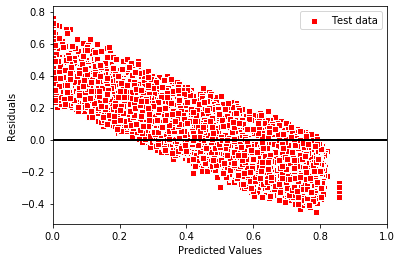

In [315]:
def resids(real, predicted):
    
    plt.scatter(real, predicted - real,
                c = 'red', marker = 's', edgecolor = 'white',
                label = 'Test data')
#     plt.scatter(ys2_train, (y_pred_train - ys2_train),
#                 c = 'steelblue', marker = 'o', edgecolor = 'white',
#                label='Train data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='bottom right')
    plt.hlines(y = 0, xmin = 0, xmax = 1, color = 'black', lw = 2)
    plt.xlim([0, 1])
    plt.show()
print('MSE test: ', ((sklm_pred - y_test_r)**2).mean(),
      "CV scores : ", scores)

resids(y_test_r, sklm_pred)

### Bayesian Ridge Regression

In [23]:
import pandas as pd
s2_train = pd.read_csv('./s2_train.csv')
s2_test = pd.read_csv('./s2_test.csv')
ys2_train = pd.read_csv('./ys2_train.csv', header=None)
ys2_test = pd.read_csv('./ys2_test.csv', header=None)

In [14]:
from sklearn.linear_model import BayesianRidge
from sklearn import linear_model

clf = linear_model.BayesianRidge()
clf.fit(s2_train, ys2_train)

In [26]:
clf_pred = clf.predict(s2_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, s2_train, ys2_train, cv=5)

In [35]:
clf_pred1 = pd.DataFrame(clf_pred)

In [36]:
#print('MSE training: ', ((y_pred_train - ys2_train)**2).mean())
print('MSE test: ', ((clf_pred1 - ys2_test)**2).mean(),
      "CV scores : ", scores)

MSE test:  0    0.030478
dtype: float64 CV scores :  [0.17217932 0.17535336 0.18048901 0.17397746 0.17594533]


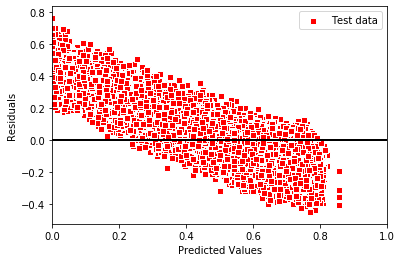

In [39]:
def resids(real, predicted):
    
    plt.scatter(real, predicted - real,
                c = 'red', marker = 's', edgecolor = 'white',
                label = 'Test data')
#     plt.scatter(ys2_train, (y_pred_train - ys2_train),
#                 c = 'steelblue', marker = 'o', edgecolor = 'white',
#                label='Train data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='bottom right')
    plt.hlines(y = 0, xmin = 0, xmax = 1, color = 'black', lw = 2)
    plt.xlim([0, 1])
    plt.show()

resids(ys2_test, clf_pred1)

In [40]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 1)
lasso.fit(s2_train, ys2_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [41]:
lasso_pred = lasso.predict(s2_test)
lasso_pred1 = pd.DataFrame(lasso_pred)

In [45]:
scores = cross_val_score(lasso, s2_train, ys2_train, cv=5)
#print('MSE training: ', ((y_pred_train - ys2_train)**2).mean())
print('MSE test: ', ((lasso_pred1 - ys2_test)**2).mean(),
      "CV scores : ", scores)

MSE test:  0    0.034775
dtype: float64 CV scores :  [-0.19278875  0.06121976  0.06363635  0.05735679  0.06442171]


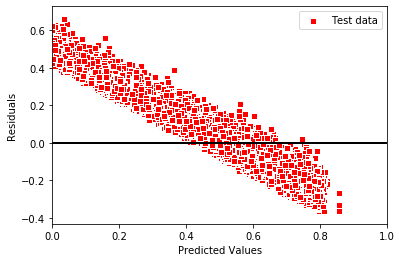

In [46]:
resids(ys2_test, lasso_pred1)

## 2.4 Analyze the results using your chosen method of evaluation (Q2D) <a class="anchor" id="Analyze"></a>


Fill

## 2.5 Discuss the advantages of each model for each classification task (Q2E) <a class="anchor" id="Advantages"></a>


Fill

## 2.6 Which attributes from your analysis are most important (Q2F) <a class="anchor" id="Attributes"></a>


Fill

# 3. Stage Five - Deployment (Q3) <a class="anchor" id="Deployment"></a>

## 3.1 Next Stage Deployment <a class="anchor" id="Deployment"></a>

The next stage in the CRISP-DM is deployment. After model building and evaluation, we are ready to deploy our code representation of the model into a production environment and solve our original business problem.
Our business problem is to give Home Credit loan evaluators access to a model that evaluates an applicant’s current and past financial history in determining whether to approve the requested loan.

The models that we have developed above will be used to determine this business question. Depending on the resources,  available, models can be deployed as batch or real-time predictions. Home Credits current process is a batch implementation. The applicant fills out the form which is then digitized and sent to the loan approval department. During the loan approval, the collected data will need to be cleaned and normalized before processed through the machine learning predictive model. The metrics for the customer is continually updated. On a scheduled cycle, this new dataset is analyzed through the current model. Doing batch cycles will allow for consistency in whether an applicant is approved or not.

However, model designs will change as newer technology are available or changing business environments make reengineering required.

Below is a typical example of a batch deployment \[1\].

<img src="./batchdeployment_process.png" style="width:800px;height:375px"/>


#### ANSWER THE FOLLOWING 
* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 
* How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? 
* What other data should be collected? How often would the model need to be updated, etc.? 


## References

\[1\] J. Kervizic, Overview of Different Approaches to Deploying Machine Learning Models in Production, June 2016.
Accessed on: Feb. 15, 2019. \[Online\].
Available: https://www.kdnuggets.com/2019/06/approaches-deploying-machine-learning-production.html




# A1. Disclaimer<a class="anchor" id="Disclaimer"></a>

## Disclaimer for Home Credit Default Research Paper
If you require any more information or have any questions about this papers disclaimer, please feel free to contact us by email at mschwan@smu.edu
## Disclaimers for Home Credit Default Research Paper
All the information for this research paper is published in good faith and for general information purpose only. Spring 2020 SMU Machine Learning One project team Schwan, Adams, Stewart, and Howard does not make any warranties about the completeness, reliability, and accuracy of this information. Any action you take upon the information you find within this paper is strictly at your own risk. This project team will not be liable for any losses and/or damages in connection with the use of our research analysis paper.
From our references, you can visit other websites and papers by following hyperlinks to such external sites. While we strive to provide only quality research references to useful and ethical content, we have no control over the content and nature of these sites. These links to other websites and papers do not imply a recommendation for all the content found within. Please be also aware that when you leave our website, other sites may have different privacy policies and terms which are beyond our control. Please be sure to check the Privacy Policies of these sites as well as their “Terms of Service” before engaging in any business or uploading any information.
## Consent
By reading our research paper content, you hereby consent to our disclaimer and agree to its terms.
## Update
Should we update, amend or make any changes to this document, those changes will be prominently posted here.



# A2. Parameter Tuning

## Random Forest

```python
scores = ['precision', 'recall']

# tuning parameters
tuned_parameters = [{'min_samples_leaf':[2,3,4,5],
                    'min_samples_split': [12,16,18,20],
                    'max_depth': [16,24,32]}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(random_state = 42),
        tuned_parameters,
        scoring='%s_macro' % score
    )
    clf.fit(data_final.drop('TARGET', axis = 1)[average_weights.iloc[0:100].Feature]
            , data_final.TARGET)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test[average_weights.iloc[0:100].Feature])
    classification_report(y_true, y_pred)
    print()
    # save off the cv objects
    if score == 'precision':
        pre_cv = clf
    else: 
        recall_cv = clf
```

In [9]:
IFrame("./rf_tuning.html", width=800, height=400)